# Exp5: Graph Convolutional Network
在给定的三个图数据下，使用GCN模型做节点分类与链路预测；  
分析自环、层数、DropEdge、PairNorm、激活函数等因素对GCN在两个下游任务性能的影响。

## 1. 准备工作

### 1.1 数据集介绍
**Cora数据集**

由机器学习论文组成，是近年来图深度学习很喜欢使用的数据集。该数据集共2708个样本点，每个样本点都是一篇科学论文，所有样本点被分为8个类别，类别分别是：
1）基于案例；2）遗传算法；3）神经网络；4）概率方法；5）强化学习；6）规则学习；7）理论

每篇论文都由一个1433维的词向量表示，所以，每个样本点具有1433个特征。词向量的每个元素都对应一个词，且该元素只有0或1两个取值。取0表示该元素对应的词不在论文中，取1表示在论文中。所有的词来源于一个具有1433个词的字典。

每篇论文都至少引用了一篇其他论文，或者被其他论文引用，也就是样本点之间存在联系，没有任何一个样本点与其他样本点完全没联系。如果将样本点看做图中的点，则这是一个连通的图，不存在孤立点。

**CiteSeer数据集**

引文网络。论文分为六类：Agents、AI（人工智能）、DB（数据库）、IR（信息检索）、ML（机器语言）和HCI。
共包含3312篇论文，记录了论文之间引用或被引用信息。去除停用词和在文档中出现频率小于10次的词，整理得到3703个唯一词。


**PPI(生物化学结构)** 

PPI网络是蛋白质相互作用（Protein-Protein Interaction,PPI）网络的简称。
PPI是指两种或以上的蛋白质结合的过程，通常旨在执行其生化功能。一般地，如果两个蛋白质共同参与一个生命过程或者协同完成某一功能，都被看作这两个蛋白质之间存在相互作用。多个蛋白质之间的复杂的相互作用关系可以用PPI网络来描述。
PPI数据集共24张图，每张图对应不同的人体组织，平均每张图有2371个节点，共56944个节点818716条边，每个节点特征长度为50，其中包含位置基因集，基序集和免疫学特征。基因本体基作为label(总共121个)。

（ppi数据集需要大家自己再进行一下数据结构的处理 可以仿照Cora和CiteSeer数据集）

**注**：数据集维度对不上可能是数据清理的方式不同，但一般情况下，GCN在cora数据集上做节点分类可以得到80%以上的准确率，在citeseer上做节点分类可以达到70%以上的准确率。如果准确率相差很大，可能是模型实现有误。

### 1.2 环境配置
```
pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
pip install torch-geometric
```

### 1.3 数据预处理

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from datetime import datetime
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, PairNorm
import random
import matplotlib.pyplot as plt
import os.path as osp
from sklearn.metrics import accuracy_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch.optim import lr_scheduler
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import negative_sampling

import warnings
warnings.simplefilter('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

对于前两个数据集，我们进行以下处理，返回 data 和 labels

In [2]:
def get_data(data_name):
    data_edge_path = f'dataset/{data_name}/{data_name}.cites'
    data_content_path = f'dataset/{data_name}/{data_name}.content'

    raw_content = pd.read_csv(data_content_path, header=None, sep='\t', low_memory=False)
    raw_edge = pd.read_csv(data_edge_path, header=None, sep='\t', low_memory=False)

    paper_ids = raw_content[0]
    paper_id_map = {}
    for i, pp_id in enumerate(paper_ids):
        paper_id_map[pp_id] = i

    edge_index = torch.from_numpy(
        raw_edge.apply(lambda col: col.map(paper_id_map)).dropna().values).long().t().contiguous()
    x = torch.from_numpy(
        raw_content.values[:, 1:-1].astype(np.float64)).float()

    labels = np.unique(raw_content[raw_content.keys()[-1]]).tolist()
    y = torch.from_numpy(
        raw_content[raw_content.keys()[-1]].map(lambda x: labels.index(x)).values).long()


    def get_mask(y: torch.tensor):
        train_mask = torch.tensor([False] * y.shape[0])
        for i in torch.unique(y).unbind():
            temp = torch.arange(0, y.shape[0])[y == i].tolist()
            random.shuffle(temp)
            train_mask[temp[:30]] = True

        train_mask = torch.tensor(train_mask)
        test_mask = train_mask == False
        return train_mask, test_mask


    train_mask, test_mask = get_mask(y)
    data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

    return data, labels

对于 PPI 数据集，采用torch_geometric 自带的 API

In [3]:
def data_loader():
    path = './dataset/ppi2'
    train_dataset = PPI(path, split='train')
    val_dataset = PPI(path, split='val')
    test_dataset = PPI(path, split='test')
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, val_loader, test_loader

## 2. 节点预测 
### 2.1 模型搭建

In [4]:
def drop_edge(edge_index, keep_ratio: float = 1.):
    num_keep = int(keep_ratio * edge_index.shape[1])
    temp = [True] * num_keep + [False] * (edge_index.shape[1] - num_keep)
    random.shuffle(temp)
    return edge_index[:, temp]


class GCNNodeClassifier(torch.nn.Module):
    def __init__(self,
                 dim_features,
                 num_classes,
                 num_layers,
                 add_self_loops: bool = True,
                 use_pairnorm: bool = False,
                 drop_edge: float = 1.,
                 activation: str = 'relu',
                 ):
        super(GCNNodeClassifier, self).__init__()
        dim_hidden = 32

        self.gconvs = torch.nn.ModuleList(
            [GCNConv(in_channels=dim_features, out_channels=dim_hidden, add_self_loops=add_self_loops)]
            + [GCNConv(in_channels=dim_hidden, out_channels=dim_hidden, add_self_loops=add_self_loops) 
               for i in range(num_layers - 2)]
        )
        self.final_conv = GCNConv(
            in_channels=dim_hidden, out_channels=num_classes, add_self_loops=add_self_loops)

        self.use_pairnorm = use_pairnorm
        if self.use_pairnorm:
            self.pairnorm = PairNorm()
        self.drop_edge = drop_edge
        activations_map = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid,
                           'leaky_relu': torch.nn.LeakyReLU(0.1)}
        self.activation_fn = activations_map[activation]

    def forward(self, x, edge_index):
        for l in self.gconvs:
            edges = drop_edge(edge_index, self.drop_edge)
            x = l(x, edges)
            if self.use_pairnorm:
                x = self.pairnorm(x)
            x = self.activation_fn(x)
        x = self.final_conv(x, edge_index)

        return x

### 2.2 模型训练

对于 Cora 和 Citeseer 数据集，由于是普通的分类任务，采用交叉熵损失来训练模型

In [5]:
def eval_acc(y_pred, y):
    return ((torch.argmax(y_pred, dim=-1) == y).float().sum() / y.shape[0]).item()


def run(dataname, test_cases, num_epochs):
    data, labels = get_data(dataname)
    x, y, edge_index, train_mask, test_mask = \
        data.x, data.y, data.edge_index, data.train_mask, data.test_mask
    best_acc = []
    for i_case, kwargs in enumerate(test_cases):
        print(f'Test Case {i_case:>2}')
        model = GCNNodeClassifier(x.shape[1], len(labels), **kwargs)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        history_test_acc = []

        for i_epoch in range(0, num_epochs):
            y_pred = model(x, edge_index)
            train_acc = eval_acc(y_pred[train_mask], y[train_mask])

            # Train
            loss = F.cross_entropy(y_pred[train_mask], y[train_mask])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Test
            test_acc = eval_acc(y_pred[test_mask], y[test_mask])
            history_test_acc.append(test_acc)
            if (i_epoch+1) % 10 == 0:
                print(f'Epoch {i_epoch+1} Train Acc = {train_acc:.4f}. Test Acc = {test_acc:.4f}')
        
        best_acc.append(max(history_test_acc))
        plt.plot(list(range(num_epochs)), history_test_acc, label=f'case_{str(i_case).zfill(2)}')

    plt.legend()
    return best_acc

对于 PPI 数据集，由于数据集较大，并且是多标签分类任务，所以将模型放入 GPU 中训练，采用 BCEWithLogitsLoss 损失，并将隐藏层节点数设置为2048

In [6]:
def run_ppi(test_cases, num_epochs):
    train_loader, val_loader, test_loader = data_loader()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = torch.nn.BCEWithLogitsLoss()

    def train(scheduler):
        model.train()

        total_loss, total_examples = 0, 0
        ys, preds = [], []
        for data in train_loader:
            ys.append(data.y)
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            preds.append((out > 0).float().cpu())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_nodes
            total_examples += data.num_nodes

        scheduler.step()
        y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
        return total_loss / total_examples, accuracy_score(y, pred)

    def test():
        model.eval()

        ys, preds = [], []
        for loader in [val_loader, test_loader]:
            for data in loader:
                ys.append(data.y)
                out = model(data.x.to(device), data.edge_index.to(device))
                preds.append((out > 0).float().cpu())

        y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
        return accuracy_score(y, pred)

    
    best_acc = []
    for i_case, kwargs in enumerate(test_cases):
        print(f'Test Case {i_case:>2}')
        model = GCNNodeClassifier(50, 121, **kwargs).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.6)

        history_test_acc = []

        for i_epoch in range(0, num_epochs):

            loss, train_acc = train(exp_lr_scheduler)
            test_acc = test()

            history_test_acc.append(test_acc)
            # if (i_epoch+1) % 10 == 0:
            print(f'Epoch {(i_epoch+1):04d} Loss = {loss:.4f}.', 
                  f'Train Acc = {train_acc:.4f}. Test Acc = {test_acc:.4f}')

        best_acc.append(max(history_test_acc))
        plt.plot(list(range(num_epochs)), history_test_acc, label=f'case_{str(i_case).zfill(2)}')

    plt.legend()
#     plt.savefig('ppi-HistoryAcc.jpg')
#     pd.DataFrame(df_test_cases).to_csv('ppi-Result.csv')
    return best_acc

### 2.3 对比试验

In [7]:
test_cases = [
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # num layers
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':6, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # self loop
    {'num_layers':2, 'add_self_loops':False, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # pair norm
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':6, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    # drop edge
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':0.6, 'activation':'relu'},
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':0.6, 'activation':'relu'},
    # activation fn
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'tanh'},
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'leaky_relu'},
]

In [8]:
# cora_best_acc = run('cora', test_cases, num_epochs=100)

In [9]:
# citeseer_best_acc = run('citeseer', test_cases, num_epochs=100)

In [10]:
# ppi_best_acc = run_ppi(test_cases, num_epochs=1000)

In [11]:
# result = pd.DataFrame(test_cases)
# result['cora_best_acc'] = cora_best_acc
# result['citeseer_best_acc'] = citeseer_best_acc
# result['ppi_best_acc'] = ppi_best_acc
# result

记录结果如下表所示：  

| num_layers | add_self_loops | use_pairnorm | drop_edge | activation | cora_best_acc | citeseer_best_acc | ppi_best_acc |
| ---------- | -------------- | ------------ | --------- | ---------- | -------- | -------- | ----------- |
| 2          | TRUE           | FALSE        | 1         | relu      | 0.764211 | 0.746197 |  0.071443 |
| 4          | TRUE           | FALSE        | 1         | relu      | 0.726982 | 0.738591 | 0.070212 |
| 6          | TRUE           | FALSE        | 1         | relu      | 0.698559 | 0.707766 | 0.068329 |
| 2          | FALSE          | FALSE        | 1         | relu      | 0.476781 | 0.469576 | 0.049826 |
| 2          | TRUE           | TRUE         | 1         | relu      | 0.67454  | 0.68775  | 0.063902 |
| 4          | TRUE           | TRUE         | 1         | relu      | 0.61209  | 0.588871 | 0.05942 |
| 6          | TRUE           | TRUE         | 1         | relu      | 0.622498 | 0.58807  | 0.057974 |
| 2          | TRUE           | FALSE        | 0.6       | relu      | 0.760608 | 0.771817 | 0.073251 |
| 4          | TRUE           | FALSE        | 0.6       | relu      | 0.742194 | 0.739392 |0.07044 |
| 2          | TRUE           | FALSE        | 1         | tanh      | 0.756205 | 0.758207 | 0.072389 |
| 2          | TRUE           | FALSE        | 1         | leaky_relu | 0.744195 | 0.753002 | 0.072463 |


可以发现如下几个规律（第0个case作为基准）：  
- 增加层数后，准确率均有下降的趋势（2层最佳）
- 去掉自环之后，准确率断崖式下降，足以说明自环结构的重要性
- 加上pairnorm之后，准确率下降了近8个百分点；但在网络较深时，增加PairNorm之后准确率略有提升
- 改变激活函数，对结果影响不大（使用tanh与斜率为0.1的leaky_relu与relu进行对比）  

另外，PPI数据集的准确率只有7%左右，这显然是不合理的，我多次调参发现并没有多大的提升，感觉是网络结构的问题，于是换了以下的**GCN2Conv**来预测PPI数据集。

### 2.4 GCN2Conv

GCN2Con: The graph convolutional operator with initial residual connections and identity mapping (GCNII) from the ["Simple and Deep Graph Convolutional Networks"](https://arxiv.org/abs/2007.02133) paper.

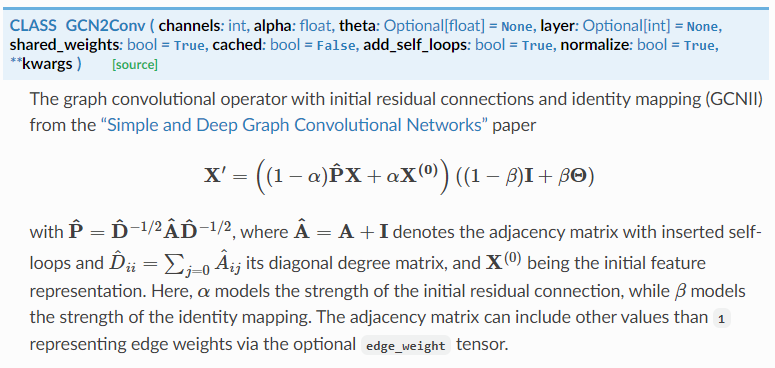

In [12]:
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, alpha, theta,
                 shared_weights=True, dropout=0.0):
        super().__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(Linear(50, hidden_channels))
        self.lins.append(Linear(hidden_channels, 121))

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, alpha, theta, layer + 1,
                         shared_weights, normalize=False))

        self.dropout = dropout

    def forward(self, x, adj_t):
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.lins[0](x).relu()

        for conv in self.convs:
            h = F.dropout(x, self.dropout, training=self.training)
            h = conv(h, x_0, adj_t)
            x = h + x
            x = x.relu()

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins[1](x)

        return x

In [13]:
from torch.nn import Linear
from torch_geometric.nn import GCN2Conv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(hidden_channels=2048, num_layers=9, alpha=0.5, theta=1.0,
            shared_weights=False, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

完整代码见 gcn2_ppi.py，可直接运行。  
运行2000个epoch可以达到 **97%** 以上的准确率。  
（该程序耗时过长，而且效果已经非常好了，便没有做对比试验）
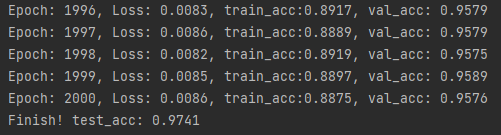

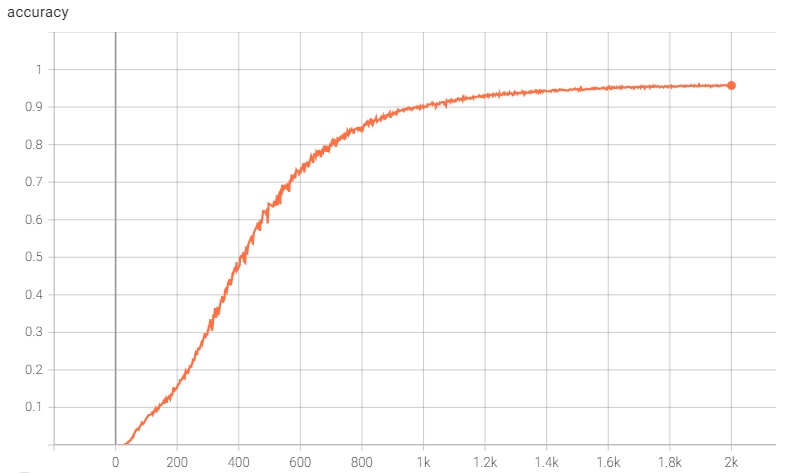

## 3. 链路预测

### 3.1 模型搭建

将链路预测定义为一个二分类的问题：

- 将图中的每个边都视为正样本
- 对不存在边的节点进行负采样
- 将正样本和负样本都放入训练集和测试集
- 用任意一个二分类器对模型进行评价，然后计算准确率

In [14]:
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self,
                 dim_features,
                 num_classes,
                 num_layers,
                 add_self_loops: bool = True,
                 use_pairnorm: bool = False,
                 drop_edge: float = 1.,
                 activation: str = 'relu',
                 ):
        super(GCNLinkPrediction, self).__init__()
        dim_hidden = 128

        self.gconvs = torch.nn.ModuleList(
            [GCNConv(in_channels=dim_features, out_channels=dim_hidden, add_self_loops=add_self_loops)]
            + [GCNConv(in_channels=dim_hidden, out_channels=dim_hidden, add_self_loops=add_self_loops)
               for i in range(num_layers - 2)]
        )
        self.final_conv = GCNConv(
            in_channels=dim_hidden, out_channels=num_classes, add_self_loops=add_self_loops)

        self.use_pairnorm = use_pairnorm
        if self.use_pairnorm:
            self.pairnorm = PairNorm()
        self.drop_edge = drop_edge
        activations_map = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid,
                           'leaky_relu': torch.nn.LeakyReLU(0.1)}
        self.activation_fn = activations_map[activation]

    def encode(self, x, edge_index):
        for l in self.gconvs:
            edges = drop_edge(edge_index, self.drop_edge)
            x = l(x, edges)
            if self.use_pairnorm:
                x = self.pairnorm(x)
            x = self.activation_fn(x)
        x = self.final_conv(x, edge_index)

        return x

    def decode(self, z, edge_label_index):
        # cosine similarity
        edge_label_index = edge_label_index.type(torch.long)
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim = -1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple = False).t()

### 3.2 模型训练

采用 BCEWithLogitsLoss 损失，以预测准确率为评价指标，阈值取0.7

In [15]:
def train(train_loader, model, optimizer):

    criterion = torch.nn.BCEWithLogitsLoss()
    model.train()
    total_examples = total_loss = 0
    for batch in train_loader: 
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch.batch_size
        z = model.encode(batch.x, batch.edge_index)
        neg_edge_index = negative_sampling(
            edge_index = batch.edge_index, num_nodes = batch.num_nodes, 
            num_neg_samples = None, method = 'sparse')
        neg_edge_index = neg_edge_index.to(device)  
        edge_label_index = torch.cat([batch.edge_index, neg_edge_index], dim = -1, )
        edge_label = torch.cat([
            torch.ones(batch.edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim = 0)
        edge_label = edge_label.to(device)
        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        total_examples += batch_size
        total_loss += float(loss) * batch_size
        
    return total_loss / total_examples


def test(loader, model, optimizer):
    
    model.eval()
    scores = []
    threshold = torch.tensor([0.7])
    for batch in loader: 
        if batch.edge_index.size(1) == 0:
            break
        batch = batch.to(device)
        z = model.encode(batch.x, batch.edge_index)
        out = model.decode(z, batch.edge_index).view(-1).sigmoid().cpu()
        pred = (out > threshold).float() * 1
        score = accuracy_score(np.ones(batch.edge_index.size(1)), pred.cpu().numpy())
        scores.append(score)
        
    return np.average(scores)

In [16]:
def run(data_name, epochs=100):
    
    data, _ = get_data(data_name)
    batch_size = 16
    train_loader = NeighborLoader(data, num_neighbors=[10]*2, 
                                  shuffle=True, input_nodes=data.train_mask, batch_size=batch_size)
    test_loader = NeighborLoader(data, num_neighbors=[10]*2, 
                                 input_nodes=data.test_mask, batch_size=batch_size)
    best_acc = []
    for i_case, kwargs in enumerate(test_cases):
        print(f'Test Case {i_case:>2}')
        model = GCNLinkPrediction(data.num_features, 64, **kwargs).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
        history_test_acc = []

        for epoch in range(0, epochs):
            loss = train(train_loader, model, optimizer)
            val_acc = test(test_loader, model, optimizer)
            history_test_acc.append(val_acc)
            print(f"Epoch: {epoch+1:03d}, Train Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
        best_acc.append(max(history_test_acc))
        
    return best_acc

没有加任何技术的话，训练结果如下图（其中蓝色曲线为cora数据集，橙色曲线为citeseer数据集）：
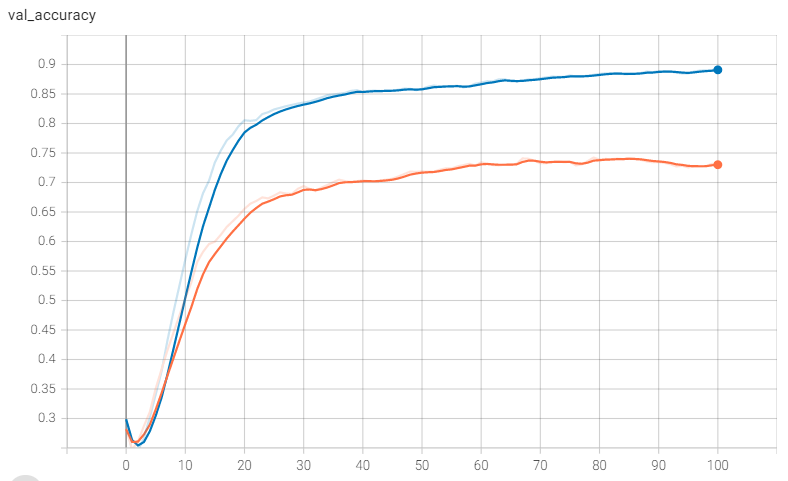

### 3.3 对比试验

In [17]:
test_cases = [
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # num layers
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':6, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # self loop
    {'num_layers':2, 'add_self_loops':False, 'use_pairnorm':False, 'drop_edge':1., 'activation':'relu'},
    # pair norm
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    {'num_layers':6, 'add_self_loops':True, 'use_pairnorm':True, 'drop_edge':1., 'activation':'relu'},
    # drop edge
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':0.6, 'activation':'relu'},
    {'num_layers':4, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':0.6, 'activation':'relu'},
    # activation fn
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'tanh'},
    {'num_layers':2, 'add_self_loops':True, 'use_pairnorm':False, 'drop_edge':1., 'activation':'leaky_relu'},
]

In [18]:
# cora_best_acc = run('cora', epochs=100)
# citeseer_best_acc = run('citeseer', epochs=100)

In [19]:
# result = pd.DataFrame(test_cases)
# result['cora_best_acc'] = cora_best_acc
# result['citeseer_best_acc'] = citeseer_best_acc
# result

计算结果如下：

| num_layers | add_self_loops | use_pairnorm | drop_edge | activation | cora_best_acc | citeseer_best_acc |
| ---------- | -------------- | ------------ | --------- | ---------- | ------------- | ----------------- |
| 2          | TRUE           | FALSE        | 1         | relu       | 0.901385      | 0.734557          |
| 4          | TRUE           | FALSE        | 1         | relu       | 0.848281      | 0.528619          |
| 6          | TRUE           | FALSE        | 1         | relu       | 0.761168      | 0.423112          |
| 2          | FALSE          | FALSE        | 1         | relu       | 0.078673      | 0.106671          |
| 2          | TRUE           | TRUE         | 1         | relu       | 0.710175      | 0.406066          |
| 4          | TRUE           | TRUE         | 1         | relu       | 0.730139      | 0.453951          |
| 6          | TRUE           | TRUE         | 1         | relu       | 0.733778      | 0.546875          |
| 2          | TRUE           | FALSE        | 0.6       | relu       | 0.87875       | 0.702386          |
| 4          | TRUE           | FALSE        | 0.6       | relu       | 0.823169      | 0.50706           |
| 2          | TRUE           | FALSE        | 1         | tanh       | **0.9385**        | **0.935335**          |
| 2          | TRUE           | FALSE        | 1         | leaky_relu | 0.893523      | 0.746623          |

可以发现如下几个规律（第0个case作为基准）：

- 增加层数后，准确率均有下降的趋势（2层最佳）
- 去掉自环之后，准确率下降了一个数量级，足以说明自环结构的重要性
- 加上pairnorm之后，准确率大幅下降；但在网络较深时，增加PairNorm的影响相对较小
- 改变激活函数，发现斜率为0.1的leaky_relu与relu相差无几，但是tanh表现十分亮眼，尤其是在citeseer数据集上，准确率直接上升了20个百分点！

使用 tanh 激活函数后，得到的曲线如下图（其中红色曲线为cora数据集，蓝色曲线为citeseer数据集）：
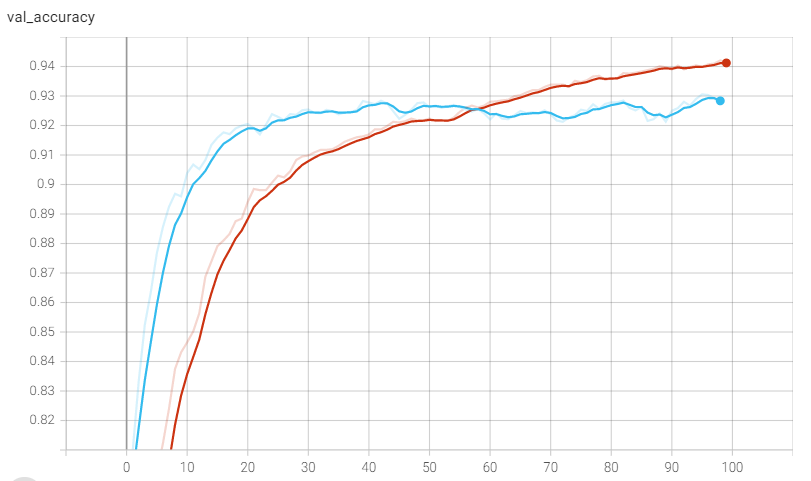

PPI数据集暂未跑通